In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Using TensorFlow backend.


In [2]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [3]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [4]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    join.columns = ['SVI', 'Temperature', 'F_M', 'Sludge Age']
    reactor_list.append(join)

In [5]:
reactor_list[2]

,SVI,Temperature,F_M,Sludge Age
date,,,,
2010-01-01,94.066570,22.030,0.22,2.92
2010-01-02,95.318860,21.985,0.22,3.04
2010-01-03,82.826748,21.740,0.22,3.00
2010-01-04,95.307918,21.815,0.22,2.97
2010-01-05,93.930636,21.890,0.23,2.94
...,...,...,...,...
2020-12-27,144.736842,22.540,0.23,3.41
2020-12-28,130.890052,22.535,0.24,3.10
2020-12-29,140.306122,22.660,0.25,3.15


In [6]:
micro_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/micro_{i+1}.csv", index_col="date")
    df.index = pd.to_datetime(df.index, dayfirst=True)
    micro_list.append(df)

In [7]:
micro_list[0]

,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,carchecium,epistylis,opercularia,podophyra,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,40.0,4.0,2.0,0.0,6.0,0.0,1.0,4.0,4.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-03-02,27.0,5.0,3.0,1.0,16.0,0.0,0.0,13.0,4.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0
2010-03-08,27.0,8.0,14.0,1.0,9.0,1.0,0.0,11.0,9.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2010-03-18,11.0,12.0,2.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-04-08,12.0,6.0,10.0,0.0,13.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,5.0,11.0,9.0,2.0,5.0,0.0,0.0,6.0,0.0,3.0,...,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,7.0,57.0,55.0,0.0,12.0,0.0,14.0,26.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-10-28,14.0,20.0,1.0,0.0,24.0,0.0,0.0,35.0,2.0,0.0,...,2.0,3.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
join_list = []
for i in range(4):
    join = pd.concat([reactor_list[i], micro_list[i]], axis=1)
    join_list.append(join)

In [9]:
join_list[1]

,SVI,Temperature,F_M,Sludge Age,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,88.649852,22.030,0.23,3.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,86.480363,21.985,0.18,3.78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,96.370968,21.740,0.21,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,109.427609,21.815,0.21,3.40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,100.929054,21.890,0.23,3.70,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,159.420290,22.540,0.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,147.887324,22.535,0.26,2.91,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,152.173913,22.660,0.26,2.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)

In [11]:
X

array([[[ 90.94368341,  22.03      ,   0.23      , ...,          nan,
                  nan,          nan],
        [ 84.36532508,  21.985     ,   0.18      , ...,          nan,
                  nan,          nan],
        [ 94.54113924,  21.74      ,   0.21      , ...,          nan,
                  nan,          nan],
        ...,
        [107.93768546,  21.89      ,   0.23      , ...,          nan,
                  nan,          nan],
        [ 89.8744113 ,  21.73      ,   0.2       , ...,          nan,
                  nan,          nan],
        [ 94.62809917,  21.655     ,   0.21      , ...,          nan,
                  nan,          nan]],

       [[ 84.36532508,  21.985     ,   0.18      , ...,          nan,
                  nan,          nan],
        [ 94.54113924,  21.74      ,   0.21      , ...,          nan,
                  nan,          nan],
        [ 97.4025974 ,  21.815     ,   0.21      , ...,          nan,
                  nan,          nan],
        ...,


In [12]:
X.shape

(16044, 7, 41)

In [13]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 49.77it/s]


In [14]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

In [15]:
X[0]

array([[0.17449926, 0.37586548, 0.3255814 , 0.27717391,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.15989432, 0.37289812, 0.20930233, 0.32336957,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        

In [16]:
Y_normalize.shape

(16044, 1)

In [18]:
#start here
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)

Epoch 1/30
14439/14439 [==============================] - 14s 967us/step - loss: 0.2177 - binary_accuracy: 0.9269
Epoch 2/30
14439/14439 [==============================] - 12s 838us/step - loss: 0.1763 - binary_accuracy: 0.9383
Epoch 3/30
14439/14439 [==============================] - 13s 892us/step - loss: 0.1580 - binary_accuracy: 0.9425
Epoch 4/30
14439/14439 [==============================] - 12s 862us/step - loss: 0.1518 - binary_accuracy: 0.9452
Epoch 5/30
14439/14439 [==============================] - 13s 884us/step - loss: 0.1474 - binary_accuracy: 0.9470
Epoch 6/30
14439/14439 [==============================] - 13s 928us/step - loss: 0.1410 - binary_accuracy: 0.9479
Epoch 7/30
14439/14439 [==============================] - 13s 925us/step - loss: 0.1383 - binary_accuracy: 0.9490
Epoch 8/30
14439/14439 [==============================] - 12s 854us/step - loss: 0.1385 - binary_accuracy: 0.9497
Epoch 9/30
14439/14439 [==============================] - 14s 956us/step - loss: 0.1377 

In [19]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [20]:
threshold = 0.5
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
y_real = Ytest.astype(int)

In [21]:
classes = ['High_svi', 'Low_svi']

In [22]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[  39   59]
 [  21 1486]]


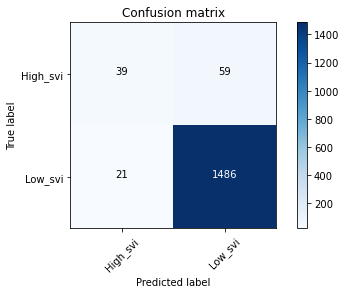

In [23]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [24]:
results = km.results(y_real, y_predict, binary=True)

In [25]:
results

(0.9501557632398754, 0.3979591836734694, 0.65, 0.49367088607594933)

In [26]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [27]:
auc(fpr, tpr)

0.9087997508226913

Text(0.5, 1.0, 'ROC curve')

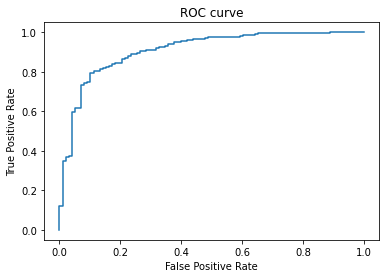

In [28]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')